In [43]:
#'os' para manipulação no proprio sistema windows
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from PIL import Image

Configuração do kaggle na maquina, a função abaixo baixa o dataset e descompacta. A propria plataforma disponibiliza a api para essa integração.

In [45]:
def kaggle_dataset_fetch(kgdata):

  os.system("pip install -q kaggle")
  os.system("rm -r -f ~/.kaggle/")
  os.system("mkdir ~/.kaggle/")
  #carrega o arquivo json
  uploaded = files.upload()
  
  if uploaded.get("kaggle.json") == None:
    raise Exception("kaggle.json was not found. Please upload again")
  
  os.system("cp kaggle.json ~/.kaggle/")
  os.system("chmod 600 /root/.kaggle/kaggle.json")
  print(f"kaggle datasets download -d {kgdata}")
  os.system(f"kaggle datasets download -d {kgdata}")

  #Descompactando
  z = os.popen("ls *.zip").read()
  os.system(f"unzip {z}")

  os.system(f"rm -f {z}")

In [46]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

O dataset não disponibiliza ja dados para treinamento e teste separadamente, por isso foi necessario essa separação.


In [75]:
def prepare_train_test(data,dir_kaggle,dir_train,test=0.3):
  
  #Criação do diretorio
  for i in data:
    shutil.copytree(f"{dir_kaggle}/{i}",f"{dir_train}/train_data/{i}")
    shutil.copytree(f"{dir_kaggle}/{i}",f"{dir_train}/test_data/{i}",ignore=shutil.ignore_patterns('*.*'))
  
  #Escolha aleatoria de img para teste formantando tamanho = dataset test
  for pokemon in os.listdir(f"{dir_train}/train_data/"):
    pop = os.listdir(f"{dir_train}/train_data/{pokemon}")
    test_size = len(pop) * test
    random.shuffle(pop)
    test_data = pop[-int(test_size):]
    
    for f in test_data:
      shutil.move(f"{dir_train}/train_data/{pokemon}/{f}",f"{dir_train}/test_data/{pokemon}")

Separando os diretorios

In [76]:
data = os.listdir("PokemonData")
dir_kaggle = "PokemonData"
dir_train = "PokeData"

In [77]:
prepare_train_test(data,dir_kaggle,dir_train)

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'PokeData/train_data/Abra'

In [57]:
train_path = f"{dir_train}/train_data"
test_path = f"{dir_train}/test_data"

Preparação das imagens do dataset

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

Teste de Imagens (visualizaçao)

In [61]:
#Escolhido dragonair
img_path = "PokeData/train_data/Dragonair/23d9b4c374914321abd2e18a18ea926a.jpg"

In [62]:
#formatação IMG
imread(img_path).shape

(300, 269, 3)

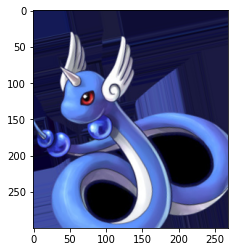

In [64]:
#Manipulado
plt.imshow(image_gen.random_transform(imread(img_path)))

Aplicar no diretorio completo enviando para path

In [65]:
#Treino
image_gen.flow_from_directory(train_path)

Found 4838 images belonging to 150 classes.


In [66]:
#Teste
image_gen.flow_from_directory(test_path)

Found 1982 images belonging to 150 classes.


CNN

In [ ]:
#Formatando IMG
image_shape = (256,256,3)

Base de entendimento para criação model usando Relu, accuracy

https://www.youtube.com/watch?v=YAn3FijMPGo&list=PLpAVc-5L0TX_draNYxCmjgm2yYKAy9aIp&index=19
https://www.youtube.com/watch?v=V5SFLCTcY_0
https://www.youtube.com/watch?v=oNUANt5jsq8

In [68]:
model = Sequential()

model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(1024,activation='relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(512,activation='relu'))

model.add(Dense(150,activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Dados Modelo


In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 256)     7168      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 256)    1024      
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 256)     590080    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                      

Definindo tamanho

In [ ]:
batch_size = 32

Gerando Treinamento

In [72]:
#Treino
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 4838 images belonging to 150 classes.


In [73]:
#Teste
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1982 images belonging to 150 classes.


In [74]:
#Treinando
results = model.fit(train_image_gen,epochs=1,validation_data=test_image_gen)

303/303 [==============================] - 3294s 11s/step - loss: 4.8683 - accuracy: 0.0254 - val_loss: 6.0480 - val_accuracy: 0.0121


In [78]:
model.save('PokemonCNN.h5')

In [79]:
model.evaluate(test_image_gen)

124/124 [==============================] - 445s 4s/step - loss: 6.0465 - accuracy: 0.0121


[6.046545028686523, 0.012108980678021908]